In [110]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from skimage import data, util, filters, color, measure, morphology, feature, segmentation, transform
from scipy import ndimage

## Zadanie 1: Segmentacja poprzez progowanie

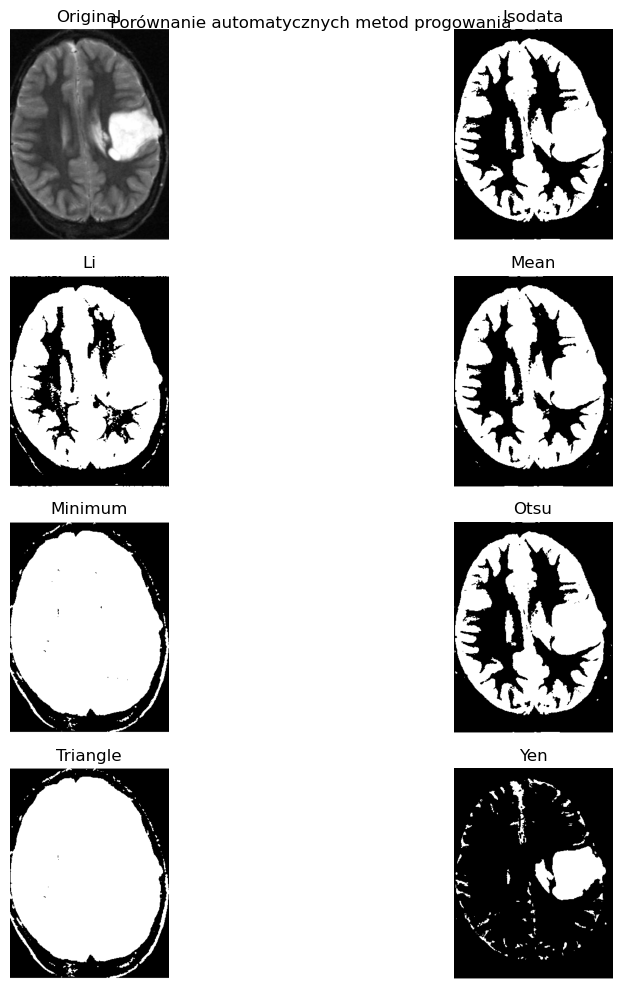

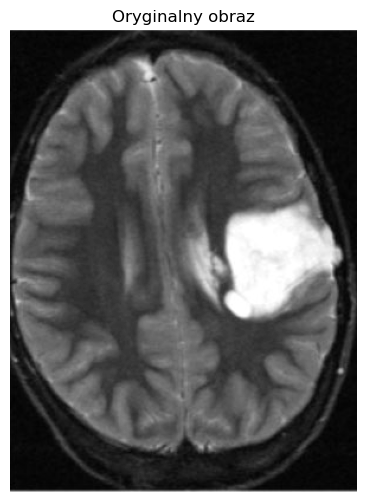

In [111]:
brain_path = 'brain_tumor.png'
brain_image = imageio.imread(brain_path)
brain_image_u8 = util.img_as_ubyte(brain_image)

# Krok wstępny: Wyświetlenie wszystkich dostępnych progów
fig, ax = filters.try_all_threshold(brain_image_u8, figsize=(12, 10), verbose=False)
plt.suptitle("Porównanie automatycznych metod progowania")
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(brain_image_u8, cmap='gray')
plt.title("Oryginalny obraz")
plt.axis('off')
plt.show()

### Polecenie 1: Automatyczne progowanie w celu uwidocznienia mózgu

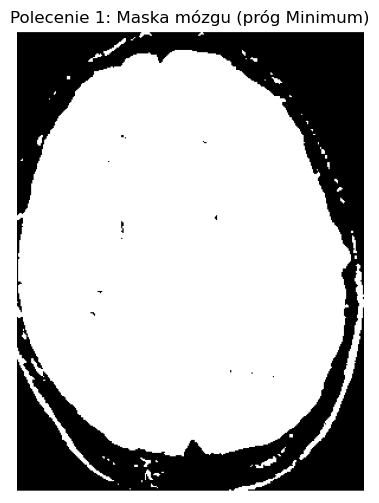

In [112]:
thresh_brain = filters.threshold_minimum(brain_image_u8)
brain_binary = brain_image_u8 > thresh_brain

plt.figure(figsize=(6, 6))
plt.imshow(brain_binary, cmap='gray')
plt.title("Polecenie 1: Maska mózgu (próg Minimum)")
plt.axis('off')
plt.show()

### Polecenie 2: Segmentacja i zliczenie obiektów

Polecenie 2: Znaleziono 57 segmentów dla całego mózgu.


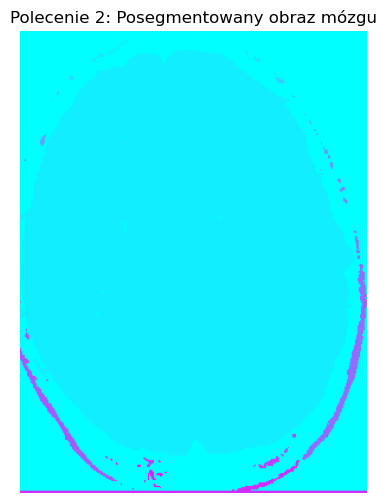

In [113]:

brain_labeled, brain_num_labels = measure.label(brain_binary, return_num=True)
print(f"Polecenie 2: Znaleziono {brain_num_labels} segmentów dla całego mózgu.")
plt.figure(figsize=(6, 6))
plt.imshow(brain_labeled, cmap='cool')
plt.title("Polecenie 2: Posegmentowany obraz mózgu")
plt.axis('off')
plt.show()


### Polecenie 3: Znalezienie największego segmentu (mózgu)

Polecenie 3: Pole powierzchni mózgu wynosi: 75226.0 pikseli.


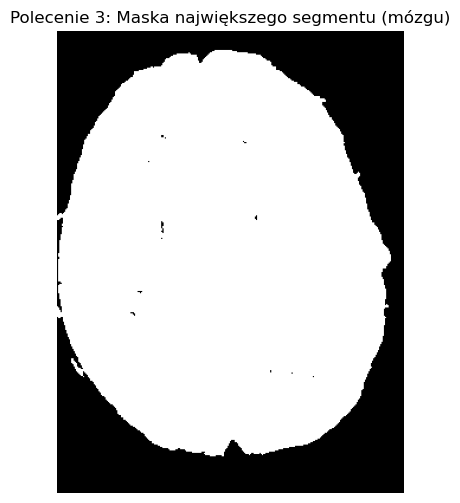

In [114]:
brain_props = measure.regionprops(brain_labeled)
# Znajdź obiekt o największej powierzchni, ignorując tło (label 0)
brain_areas = [prop.area for prop in brain_props]
largest_brain_component_index = np.argmax(brain_areas)
largest_brain_prop = brain_props[largest_brain_component_index]

brain_mask = (brain_labeled == largest_brain_prop.label)
brain_area = largest_brain_prop.area
print(f"Polecenie 3: Pole powierzchni mózgu wynosi: {brain_area} pikseli.")

plt.figure(figsize=(6, 6))
plt.imshow(brain_mask, cmap='gray')
plt.title(f"Polecenie 3: Maska największego segmentu (mózgu)")
plt.axis('off')
plt.show()

### Polecenie 4: Segmentacja guza

Polecenie 4: Pole powierzchni guza wynosi: 8034.0 pikseli.


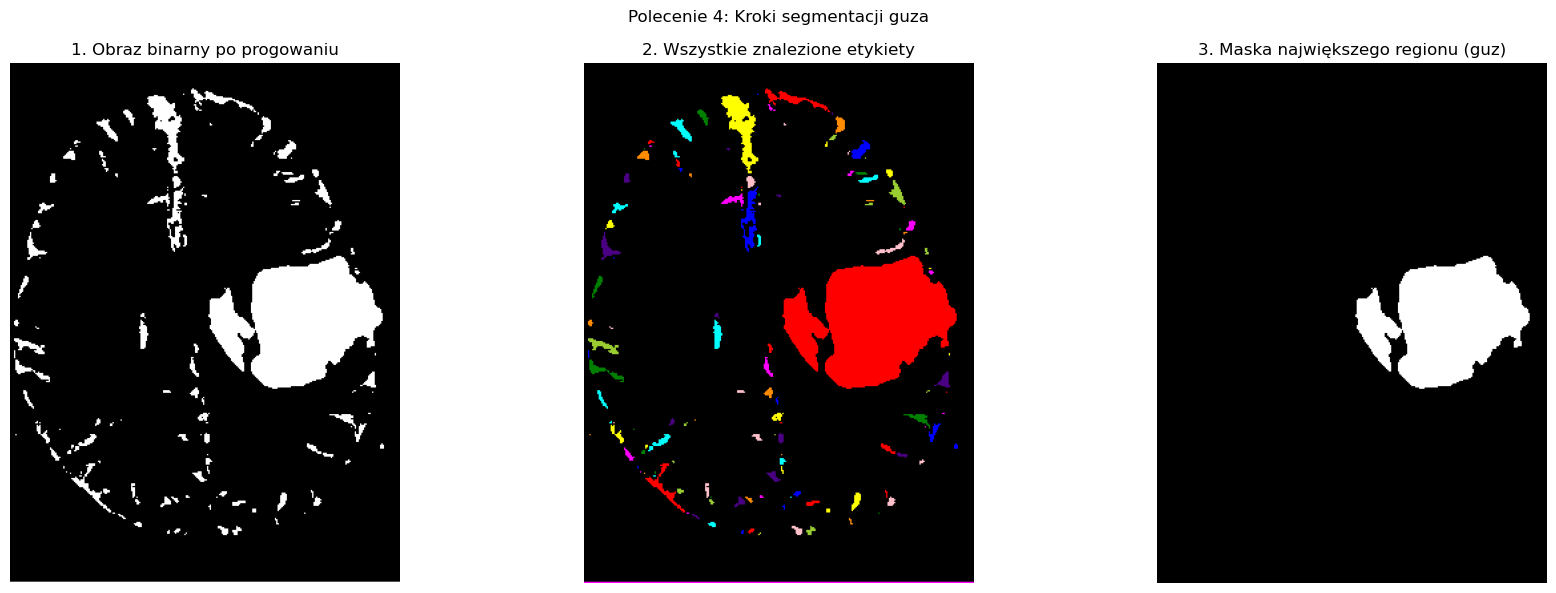

In [115]:
thresh_tumor = filters.threshold_yen(brain_image_u8)
tumor_binary = brain_image_u8 > thresh_tumor
tumor_labeled, tumor_num_labels = measure.label(tumor_binary, return_num=True)
tumor_props = measure.regionprops(tumor_labeled)

# Założenie, że guz jest największym obiektem po progowaniu Yen
tumor_areas = [prop.area for prop in tumor_props]
largest_tumor_component_index = np.argmax(tumor_areas)
largest_tumor_prop = tumor_props[largest_tumor_component_index]

tumor_mask = (tumor_labeled == largest_tumor_prop.label)
tumor_area = largest_tumor_prop.area
print(f"Polecenie 4: Pole powierzchni guza wynosi: {tumor_area} pikseli.")

fig4, axes4 = plt.subplots(1, 3, figsize=(18, 6))

axes4[0].imshow(tumor_binary, cmap='gray')
axes4[0].set_title("1. Obraz binarny po progowaniu")
axes4[0].axis('off')

axes4[1].imshow(color.label2rgb(tumor_labeled, bg_label=0))
axes4[1].set_title("2. Wszystkie znalezione etykiety")
axes4[1].axis('off')

axes4[2].imshow(tumor_mask, cmap='gray')
axes4[2].set_title("3. Maska największego regionu (guz)")
axes4[2].axis('off')

plt.suptitle("Polecenie 4: Kroki segmentacji guza")
plt.tight_layout()
plt.show()


### Polecenie 5: Złożenie obrazów i obliczenie proporcji

Polecenie 5: Guz zajmuje 10.68% powierzchni całego mózgu.


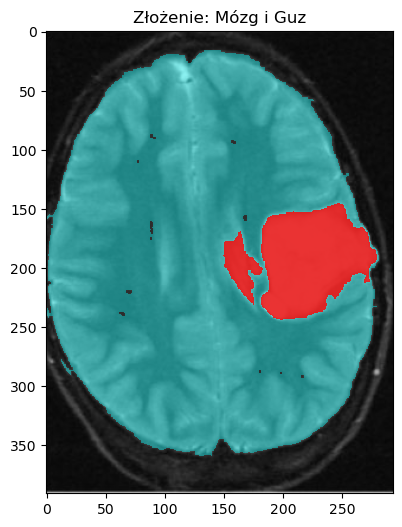

In [116]:
proportion = (tumor_area / brain_area) * 100
print(f"Polecenie 5: Guz zajmuje {proportion:.2f}% powierzchni całego mózgu.")

plt.figure(figsize=(6, 6))

overlay_image = color.gray2rgb(util.img_as_float(brain_image_u8))
brain_overlay = np.ma.masked_where(brain_mask == 0, brain_mask)
tumor_overlay = np.ma.masked_where(tumor_mask == 0, tumor_mask)
plt.imshow(overlay_image)
plt.imshow(brain_overlay, cmap='cool', alpha=0.4)
plt.imshow(tumor_overlay, cmap='autumn', alpha=0.8)
plt.title("Złożenie: Mózg i Guz")
plt.show()

## Zadanie 2: Segmentacja poprzez detekcję krawędzi

In [117]:
url_bolts = 'bolts.jpg'
bolts_image_color = imageio.imread(url_bolts)

### Polecenie 1: Przetwarzanie wstępne i detekcja krawędzi

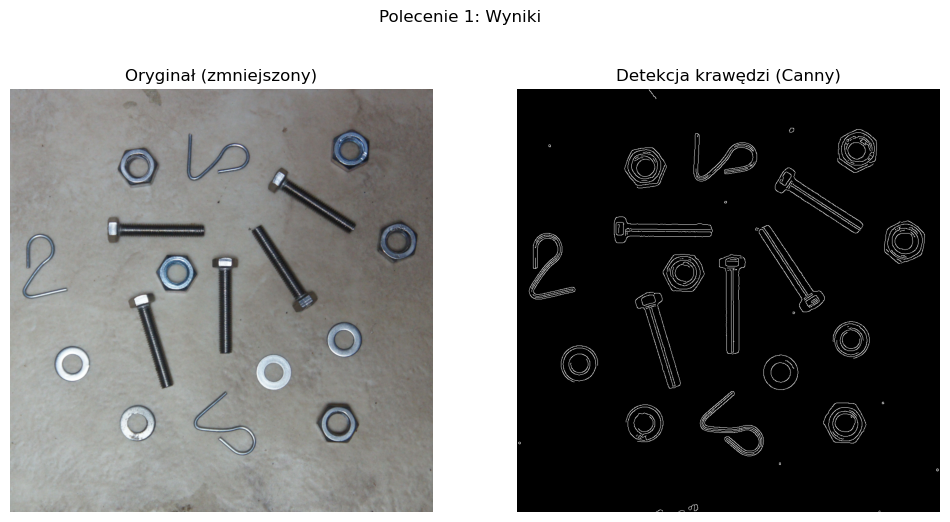

In [118]:
bolts_resized = transform.resize(bolts_image_color, (bolts_image_color.shape[0] // 3, bolts_image_color.shape[1] // 3), anti_aliasing=True)
bolts_gray = color.rgb2gray(bolts_resized)
bolts_blurred = filters.gaussian(bolts_gray, sigma=1.2)
bolts_canny = feature.canny(bolts_gray, sigma=1.5)

fig_p1, axes_p1 = plt.subplots(1, 2, figsize=(12, 6))
axes_p1[0].imshow(bolts_resized)
axes_p1[0].set_title("Oryginał (zmniejszony)")
axes_p1[0].axis('off')
axes_p1[1].imshow(bolts_canny, cmap='gray')
axes_p1[1].set_title("Detekcja krawędzi (Canny)")
axes_p1[1].axis('off')
plt.suptitle("Polecenie 1: Wyniki")
plt.show()

### Polecenie 2: Operacje morfologiczne

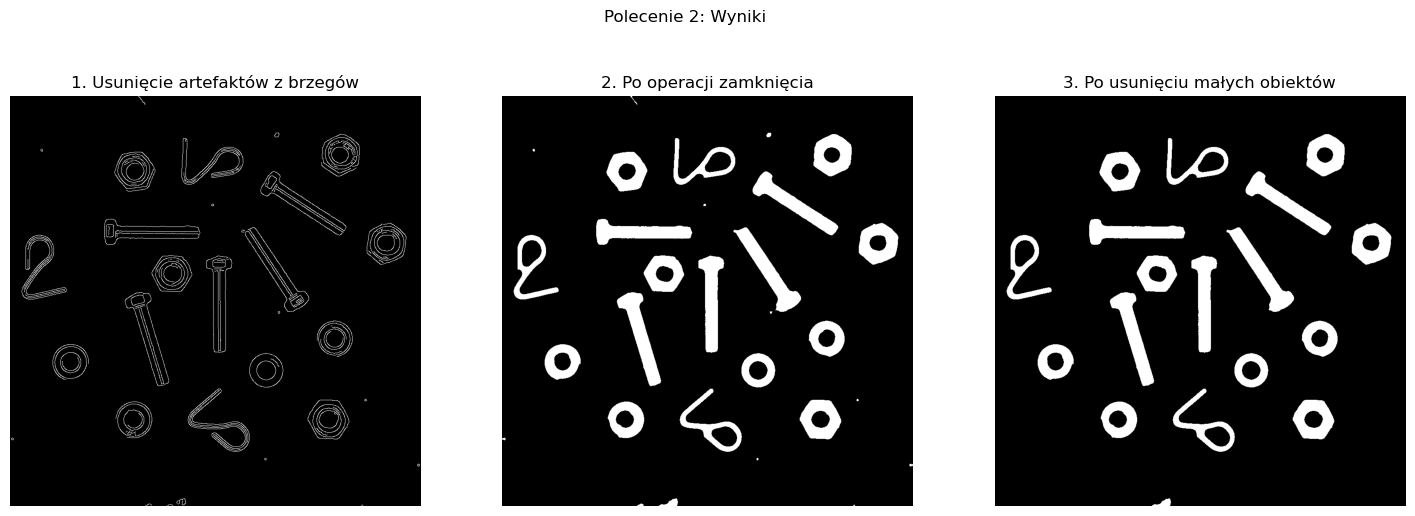

In [119]:
bolts_cleared = segmentation.clear_border(bolts_canny)
selem = morphology.disk(10)
bolts_closed = morphology.binary_closing(bolts_cleared, selem)
bolts_cleaned = morphology.remove_small_objects(bolts_closed, min_size=100)
# bolts_filled = ndimage.binary_fill_holes(bolts_closed)

fig_p2, axes_p2 = plt.subplots(1, 3, figsize=(18, 6))
axes_p2[0].imshow(bolts_cleared, cmap='gray')
axes_p2[0].set_title("1. Usunięcie artefaktów z brzegów")
axes_p2[0].axis('off')
axes_p2[1].imshow(bolts_closed, cmap='gray')
axes_p2[1].set_title("2. Po operacji zamknięcia")
axes_p2[1].axis('off')
axes_p2[2].imshow(bolts_cleaned, cmap='gray')
axes_p2[2].set_title("3. Po usunięciu małych obiektów")
axes_p2[2].axis('off')
plt.suptitle("Polecenie 2: Wyniki")
plt.show()

### Polecenie 3: Finalna segmentacja

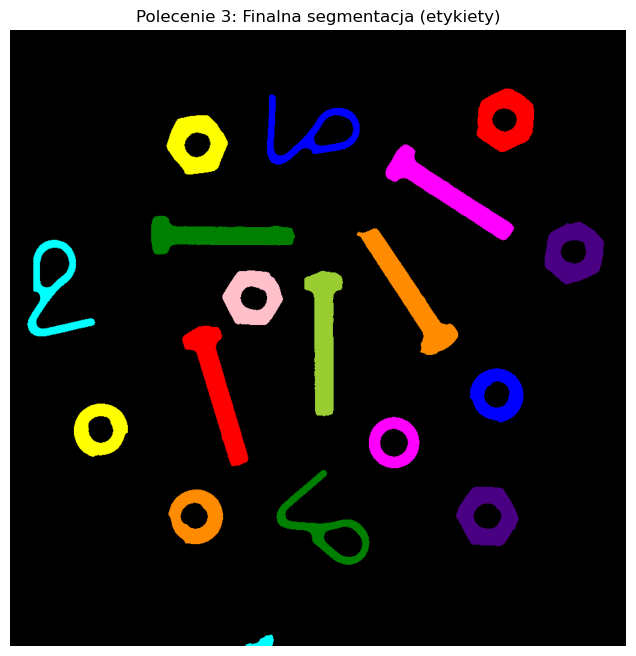

In [120]:
bolts_labeled = measure.label(bolts_cleaned)

plt.figure(figsize=(8, 8))
plt.imshow(color.label2rgb(bolts_labeled, bg_label=0))
plt.title("Polecenie 3: Finalna segmentacja (etykiety)")
plt.axis('off')
plt.show()

## Zadanie 3: Segmentacja na podstawie kształtu

Analiza właściwości obiektów:
Label | Solidity        | Eccentricity   
--------------------------------------------------
1     | 1.0000         
2     | -1.0000        
3     | 1.0000         
4     | -1.0000        
5     | 1.0000         
6     | -3.0000        
7     | -3.0000        
8     | 1.0000         
9     | -3.0000        
10    | -1.0000        


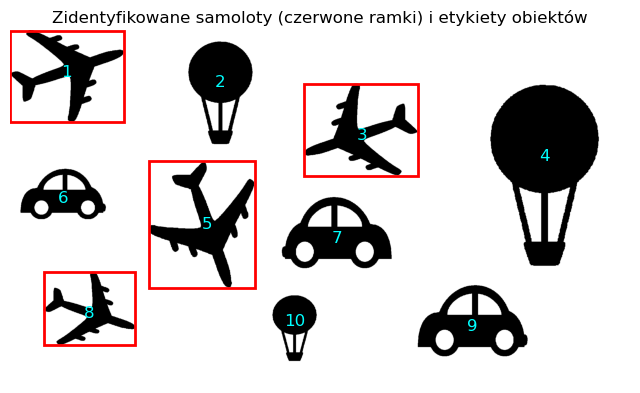

In [121]:
url_planes = 'planes.png'

planes_image_rgba = imageio.imread(url_planes)

# Konwersja z RGBA do RGB, a następnie do skali szarości
planes_rgb = color.rgba2rgb(planes_image_rgba)
planes_gray = color.rgb2gray(planes_rgb)

# Progowanie binarne, aby oddzielić obiekty (czarne) od tła (białe)
planes_binary = planes_gray < 0.5

# Usunięcie ewentualnych połączeń między obiektami za pomocą operacji otwarcia
selem_planes = morphology.disk(1)
planes_binary_cleaned = morphology.binary_opening(planes_binary, selem_planes)

# Segmentacja obiektów na oczyszczonym obrazie binarnym
planes_labeled = measure.label(planes_binary_cleaned)
planes_props = measure.regionprops(planes_labeled)

# Tworzenie obrazu wyjściowego do rysowania
fig3, ax3 = plt.subplots(1, 1, figsize=(8, 8))
ax3.imshow(planes_image_rgba)

print("Analiza właściwości obiektów:")
print(f"{'Label':<5} | {'Solidity':<15} | {'Eccentricity':<15}")
print("-" * 50)

# Iteracja po znalezionych obiektach
for prop in planes_props:
    euler_num = prop.euler_number
    print(f"{prop.label:<5} | {euler_num:<15.4f}")

    # Dodanie numeru etykiety na obrazie
    y, x = prop.centroid
    ax3.text(x, y, str(prop.label), color='cyan', fontsize=12, ha='center', va='center')

    # Kryterium klasyfikacji: samoloty mają niską zwięzłość (solidity)
    if euler_num > 0:
        # Rysowanie prostokąta otaczającego
        minr, minc, maxr, maxc = prop.bbox
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                             fill=False, edgecolor='red', linewidth=2)
        ax3.add_patch(rect)

ax3.set_title("Zidentyfikowane samoloty (czerwone ramki) i etykiety obiektów")
ax3.axis('off')
plt.show()